# Transit Timing Variations (TTV) with a modified `batman`

In [1]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile
import ellc
from copy import copy, deepcopy
from scipy.signal import find_peaks
from Planet_tools.convert_param import convert_LD_coeffs, inclination, impact_parameter

import Planet_tools as pt    
#personal useful functions. can install from https://github.com/tundeakins/Planet_tools

This modified version of batman can be found here https://github.com/tundeakins/batman. 

Install using


`git clone https://github.com/tundeakins/batman.git`

`cd batman`

`python setup.py install`

Get sector 2 light curve of WASP-18b using `lightkurve`

In [2]:
lc = search_lightcurvefile('WASP-18b',mission="TESS",sector=2).download()


In [3]:
lc1 = lc.PDCSAP_FLUX.normalize().remove_nans()#.flatten(3909)

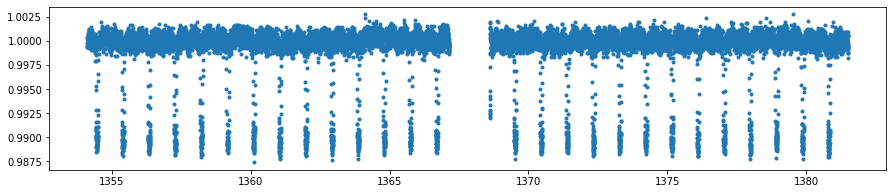

In [4]:
plt.figure(figsize=(15,3))
plt.plot(lc1.time,lc1.flux,".")

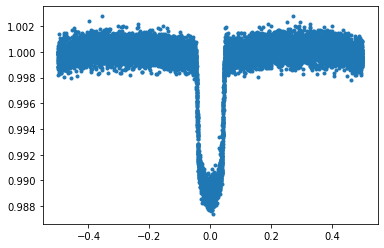

In [5]:
#fold data to get mask of transit regions
P  = 0.9414526
t_ref = 2458375.169883 - 2457000 
phases = pt.utils.phase_fold(lc1.time,P,t_ref)
plt.plot(phases, lc1.flux,".")

In [6]:
indx = abs(phases)>0.06
mask = ~indx

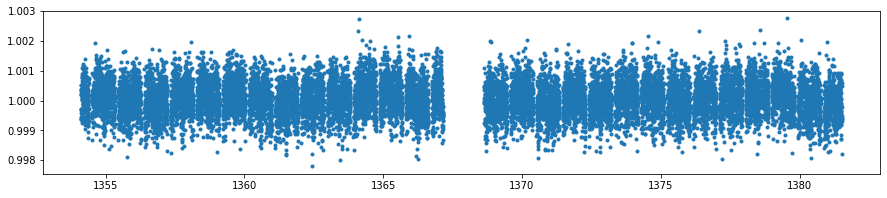

In [7]:
plt.figure(figsize=(15,3))
plt.plot(lc1.time[indx],lc1.flux[indx],".")

### perform simple detrending

In [8]:
#median filtering with transits removed
lc_det = lc1.flatten(window_length=59,mask=mask).remove_nans().\
                                remove_outliers(sigma_lower=8,sigma_upper=4)

In [9]:
t, y, e = lc_det.time, lc_det.flux, lc_det.flux_err
t = np.array([tt for tt in t])  

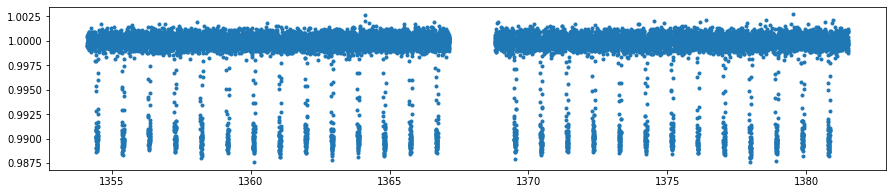

In [10]:
#remove incomplete transit around t = 1368.6

cutout = abs(t-1368.6)>0.2
t,y,e = t[cutout], y[cutout], e[cutout]

plt.figure(figsize=(15,3))
plt.plot(t,y,".");


#### modeling the light curve



transit paramters from [Shporer et al 2019](https://arxiv.org/pdf/1811.06020.pdf)

In [11]:

Rp = 0.09716 
aR = 3.562
ip = 84.88
b = impact_parameter(ip,aR)
P  = 0.9414526
t_ref = 2458375.169883 - 2457000    #reference transit time
u1, u2 = 0.2192, 0.3127 
#reparameterize according to kipping 2013, better for fitting
q1, q2 = convert_LD_coeffs(u1,u2, convert_from="u2q")   

In [12]:
###First using the standard batman model

In [13]:
def bat_model(pars, time):
    bat_params = batman.TransitParams()
    
    bat_params.per = P                    #orbital period
    bat_params.rp = pars[0]                     #planet radius (in units of stellar radii)
    bat_params.a = pars[1]                      #semi-major axis (in units of stellar radii)
    imp_par = pars[2]
    bat_params.inc = inclination(imp_par, pars[1])                    #orbital inclination (in degrees)
    bat_params.ecc = 0                    #eccentricity
    bat_params.w = 90.                      #longitude of periastron (in degrees)
    u1, u2 = convert_LD_coeffs(pars[3], pars[4], convert_from="q2u", verify=False)
    bat_params.u = [u1, u2]               #limb darkening coefficients
    bat_params.limb_dark = "quadratic"      #limb darkening model
    bat_params.t0 = pars[5]                     #time of inferior conjunction

    m = batman.TransitModel(bat_params, time)   #initializes model
    flux_batman = m.light_curve(bat_params)  #calculates light curve
    return flux_batman
 

In [14]:
pars= [Rp, aR, b, q1, q2, t_ref]
f = bat_model(pars, t)    #standard light curve

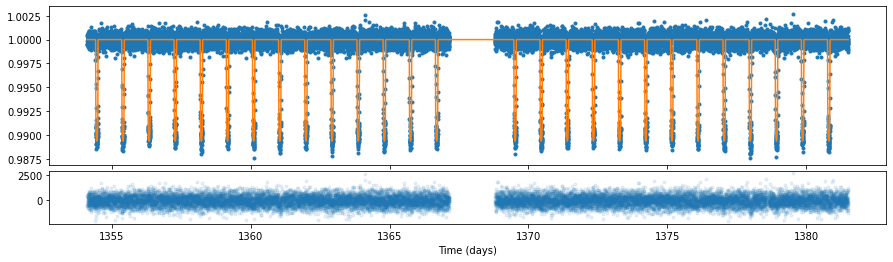

In [15]:
fig, ax = plt.subplots(2,1,figsize=(15,4), sharex=True, gridspec_kw={"height_ratios":(3,1)})
ax[0].plot(t,y,".")
ax[0].plot(t, f)
ax[1].plot(t, 1e6*(y-f),".", alpha=0.1)
plt.subplots_adjust(hspace=0.05)
plt.xlabel("Time (days)");

### TTV modifications

To model TTVs in the data, it is possible to break up the data into individual transits so that each transit can have a unique mid-transit time `T0`

To do this, i have added a function `split_transits` into the batman package.

- It uses a given reference transit time `t_ref` (can be gotten from literature) to identify times of transits and splits accordingly.

- If for some reason this is not satisfactory, it can also use Scipy's `find_peaks` algorithm to identify locations of significant dips in the light curve, which it then uses for splitting the data (rarely needed)

###### using `t_ref ` for splitting

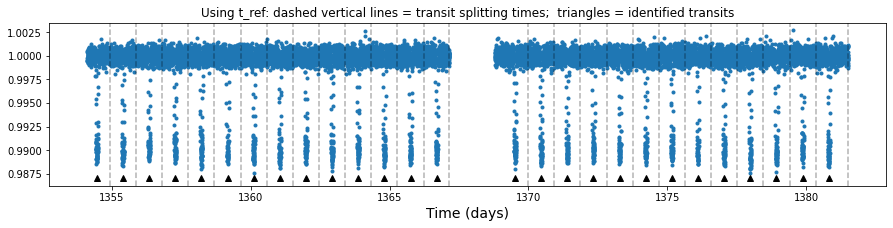

In [16]:
tr_times, tr_edges, indz, t0s = batman.split_transits(t, P, t_ref, y, show_plot=True)

We see that the transits are well identified (black arrows beneath) and the splitting edges accurately separates the individual transits

The ouputs gives:
- tr_times: list containing array of times of each transit
- tr_edges: list of split edges (shown as dashed vertical lines)
- indz: list containing array of indices of the times in tr_times
- t0s: list of identified mid-transit times

In this data, there are 27 transits which are well identified

In [17]:
len(tr_times), len(tr_edges), len(indz), len(t0s)

(27, 27, 27, 27)

The returned indices (indz) from the `split_transits` function can also be used to plot each transit separately

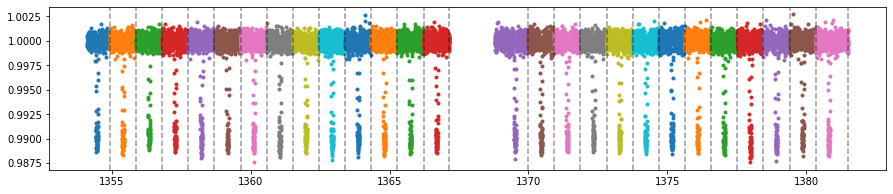

In [18]:
plt.figure(figsize=(15,3))

for i in range(len(indz)):
    plt.plot(t[indz[i]], y[indz[i]], ".")
    plt.axvline(tr_edges[i], ls="dashed", c="k", alpha=0.4, zorder=4)

##### using `find_peaks` for splitting

It uses the find_peaks algorithm to find peaks deeper than a certain `flux_value`. 
The `distance` between the peaks can also be specified to ensure that they are roughly 1 orbital period away. The default is to estimate the number of samples within a Period by calculating the mean cadence - `P/np.mean(np.diff(t))`

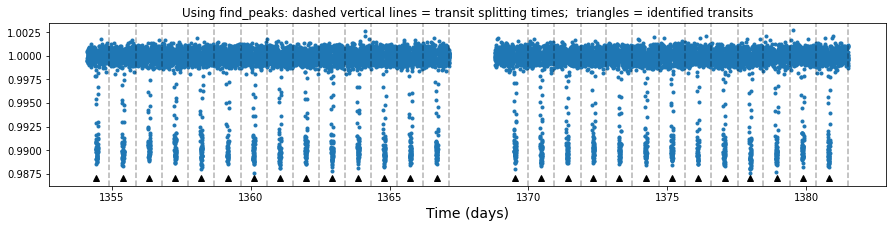

In [19]:
tr_times2,tr_edges2,indz2,t0s2 = batman.split_transits(t, P, flux= y, find_peaks=True,
                                                find_peaks_kw={"flux_value": 0.9925, "distance":None}, 
                                                   show_plot=True)

In [20]:
len(tr_times2), len(tr_edges2), len(indz2), len(t0s2)

(27, 27, 27, 27)

It performs equally good, identifying same transits as the previous method. (i think this method will be mostly uneccessary)

### Now to create a model that can be used for fitting the transit parameters and the individual T0s

In [17]:
#TTV model
def bat_ttv_model(pars,time):
    params = batman.TransitParams()
        
    params.per = P                                   #orbital period
    params.rp = pars[0]                              #planet radius (in units of stellar radii)
    params.a = pars[1]                               #semi-major axis (in units of stellar radii)
    imp_par = pars[2]
    params.inc = inclination(imp_par, params.a)      #orbital inclination (in degrees)
    params.ecc = 0                                   #eccentricity
    params.w = 90.                                   #longitude of periastron (in degrees)
    u1, u2 = convert_LD_coeffs(pars[3], pars[4],
                               convert_from="q2u",
                               verify=False)
    params.u = [u1, u2 ]                        #limb darkening coefficients
    params.limb_dark = "quadratic"              #limb darkening model
    params.t0 = pars[5:]                        #time of inferior conjunction for each transit. This c
    
    params.split_time = False                   #flag to perform time splitting within the TTV Transit function
                                                #set False if the input TIME is already a list of time arrays
    
    params.t_ref = t_ref                        #reference time used to break up the transits as illustrated before
                                                #only required if params.split_time=True
    
    #notice the different function used to calculate the transit model
    ttv_batflux = batman.TTV_TransitModel(params, time)
    
    #ttv_batflux = batman.TTV_TransitModel(params, time,flux=y, find_peaks=True,
    #                                            find_peaks_kw={"flux_value": 0.9925, "distance":None})

        
    return ttv_batflux


Notice the difference in the function that generates the light curve `batman.TTV_TransitModel`.

If `params.split_time = True`, this function first makes a function call to `split_transits` in order to split the transit in same way you have confirmed earlier to be accurate. It uses the new  `params.t_ref` value to make the split (or one can similarly use the find_peaks, in which case you specify the required inputs to use to the `batman.TTV_TransitModel`). It is important to have visualized the split before now to ensure that the transits are separated accurately so that the same inputs are then passed here.

Recommended: Use `params.split_time = False` with input time obtained from `split_transits` function. In this way, you don't perform the transit splitting everytime `bat_ttv_model` is called which saves time during mcmc.

Then it uses the t0 values in `params.t0` (which is now an array/list) to generate light curve for each transit segment. 

The result `ttv_batflux` is a concatenation of the individual transit models.

Note: to fit TTVs, `Period` and `t_ref` have to be fixed

In [18]:
#you can see the documentation 
batman.TTV_TransitModel?

##### Model a transit with TTV

In [19]:
pars= [Rp, aR, b, q1, q2]     #same as before
#extend input parameters by t0 for each transit. The model expects the last parameter values to be t0 values
pars.extend(t0s)       #starting values for T0 could be gotten from split_transits function    

#Now modify some of the t0s so that they are slightly different from values of linear ephemeris

pars[-1]=pars[-1]+0.4*P     #last transit shifted forward by 0.4*P
pars[-5]=pars[-5]-0.3*P

In [22]:
#call the model with the input params
flux_ttv = bat_ttv_model(pars, tr_times)

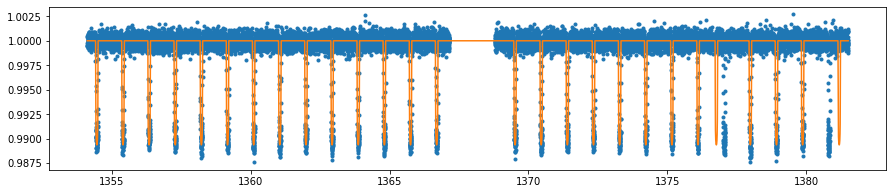

In [23]:
plt.figure(figsize=(15,3))
plt.plot(t,y,".")
plt.plot(t, flux_ttv)

Notice the shift in the 2 transits modified. Thus we can model all the transits with the same paramters but with different t0s

### MCMC
An MCMC can now be used to fit all the paramters

In [24]:
import emcee
from scipy.stats import norm, uniform, truncnorm
from multiprocessing import Pool
import corner

As before, use the `split_transits` function to create list of separated transits to pass, in order not to perform the splitting within the mcmc iterations.

In [25]:
split_t, _, _, t0s = batman.split_transits(t, P, t_ref)

In [26]:
#define priors

#priors on transit parameters
Rp_ = uniform(0.05, 0.15)
aR_ = uniform(2.5, 2)
b_ = uniform(0, 0.5)
q1_ = truncnorm(a= (0-q1)/0.05,b =(1-q1)/0.05, loc=q1, scale=0.05)
q2_ = truncnorm(a= (0-q2)/0.05,b =(1-q2)/0.05, loc=q2, scale=0.05)

priors = [Rp_, aR_, b_, q1_, q2_]

#priors on t0s
#normal priors for t0, centered on previously estimated values (t0s) with a 15 minutes width
t_width = 15/(60*24)   #to days
t0_priors = [norm(t0,t_width) for t0 in t0s]


# add to transit priors
priors.extend(t0_priors)

#add jitter prior
#priors.append(uniform(-15,15))

In [27]:
def lnprior(params):
    lp = 0.0
    for par, pr in zip(params, priors):
        lp += pr.logpdf(par)
    return lp

def lnlike(params, t, y, yerr):
    mdl = bat_ttv_model(params, t)
    return -0.5 * np.sum(((y - mdl)/yerr) ** 2)
##uncomment the following lines if fitting jitter term
    #jitt = params[-1]          
    #mdl = bat_ttv_model(params[:-1], t)
    #sigma2 = yerr**2 + mdl**2 * np.exp(2*jitt)
    #return -0.5 * np.sum((y - mdl)**2/sigma2 + np.log(sigma2) )


def lnprob(params, t, y, yerr):
    lp = lnprior(params)
    return lp + lnlike(params, t, y, yerr) if np.isfinite(lp) else -np.inf

In [28]:
ndim, nwalkers = len(priors), len(priors)*5

#starting point
pars= [Rp, aR, b, q1, q2]
pars.extend(t0s)

#pars.append(-6)     #uncomment for jitter
pos = np.array([pars + 1e-2*np.random.randn(ndim) for i in range(nwalkers)])
    
      

In [29]:
labels=["$R_{p}$", "$a/R_{\\ast}$", "$b$", "$q_{1}$", "$q_{2}$"]

t0_labels = [f"$t0_{{{i+1}}}$" for i in range(len(t0s))]

labels.extend(t0_labels)
#labels.append("jitt")  #uncomment for jitter

In [30]:
#confirm starting values are within the prior distribution
for position in pos:
    assert np.isfinite(lnprior(position)), f"lnprior of parameters: {position} is not finite"
    #assert np.isfinite(lnlike(position, split_t,y,e)), f"lnprior of parameters: {position} is not finite"

### Run mcmc
takes around 2hrs.

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(split_t, y, e),
                                pool=Pool(4))#, moves= emcee.moves.DESnookerMove())


sampler.run_mcmc(pos, 13000, progress=True);

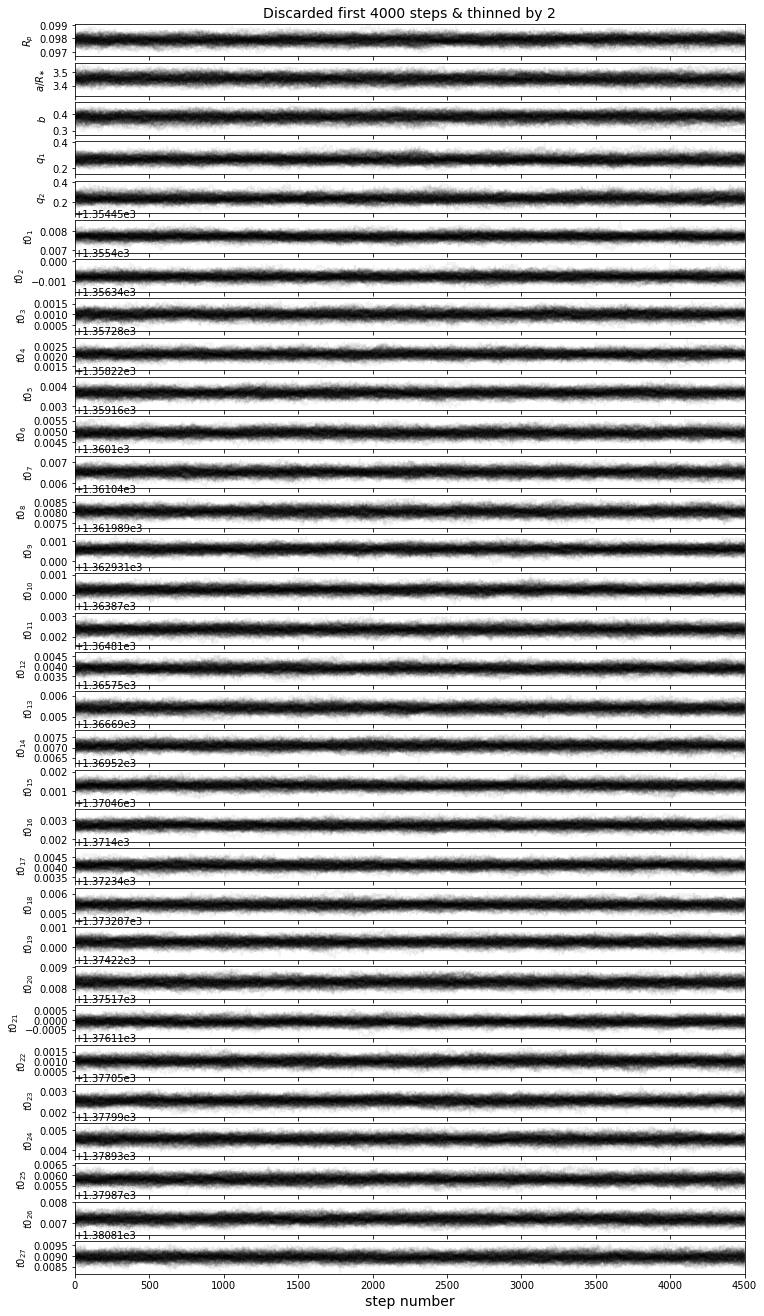

In [35]:
pt.utils.plot_emcee_chains(sampler, labels, discard=4000, thin=2);

In [ ]:
samples = sampler.chain[:, 4000::2, :].reshape((-1, ndim))

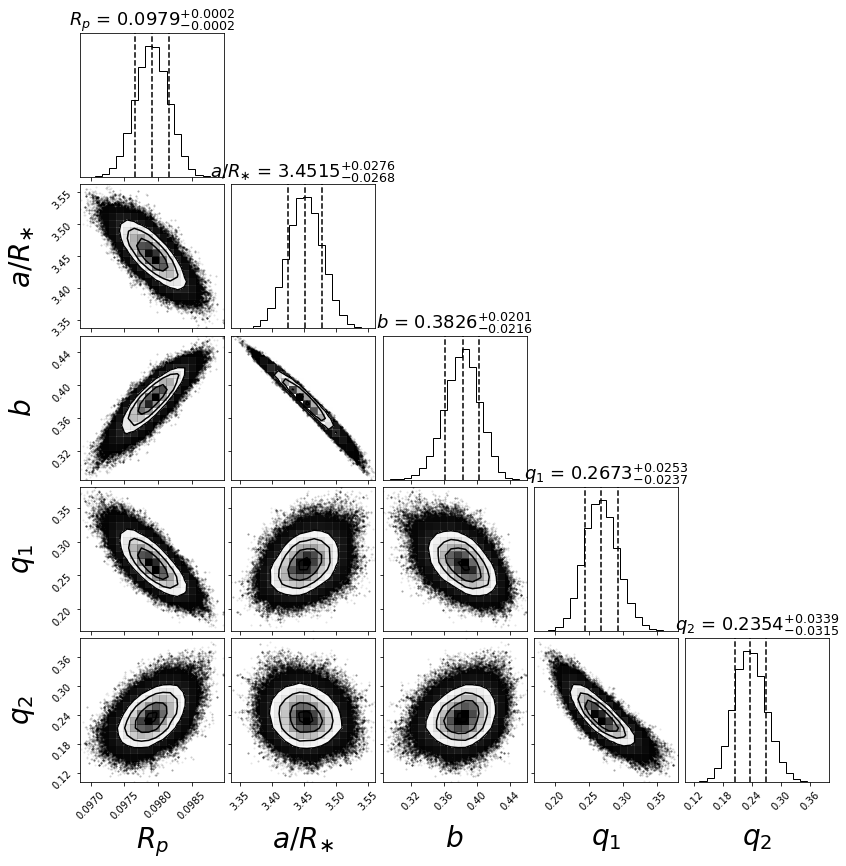

In [32]:
#main transit paramters
corner.corner(samples[:,:5], labels=labels[:5],show_titles=True,
                    title_fmt=".4f",quantiles=[0.16,0.5,0.84],title_kwargs={"fontsize": 18},
                    label_kwargs={"fontsize":28});

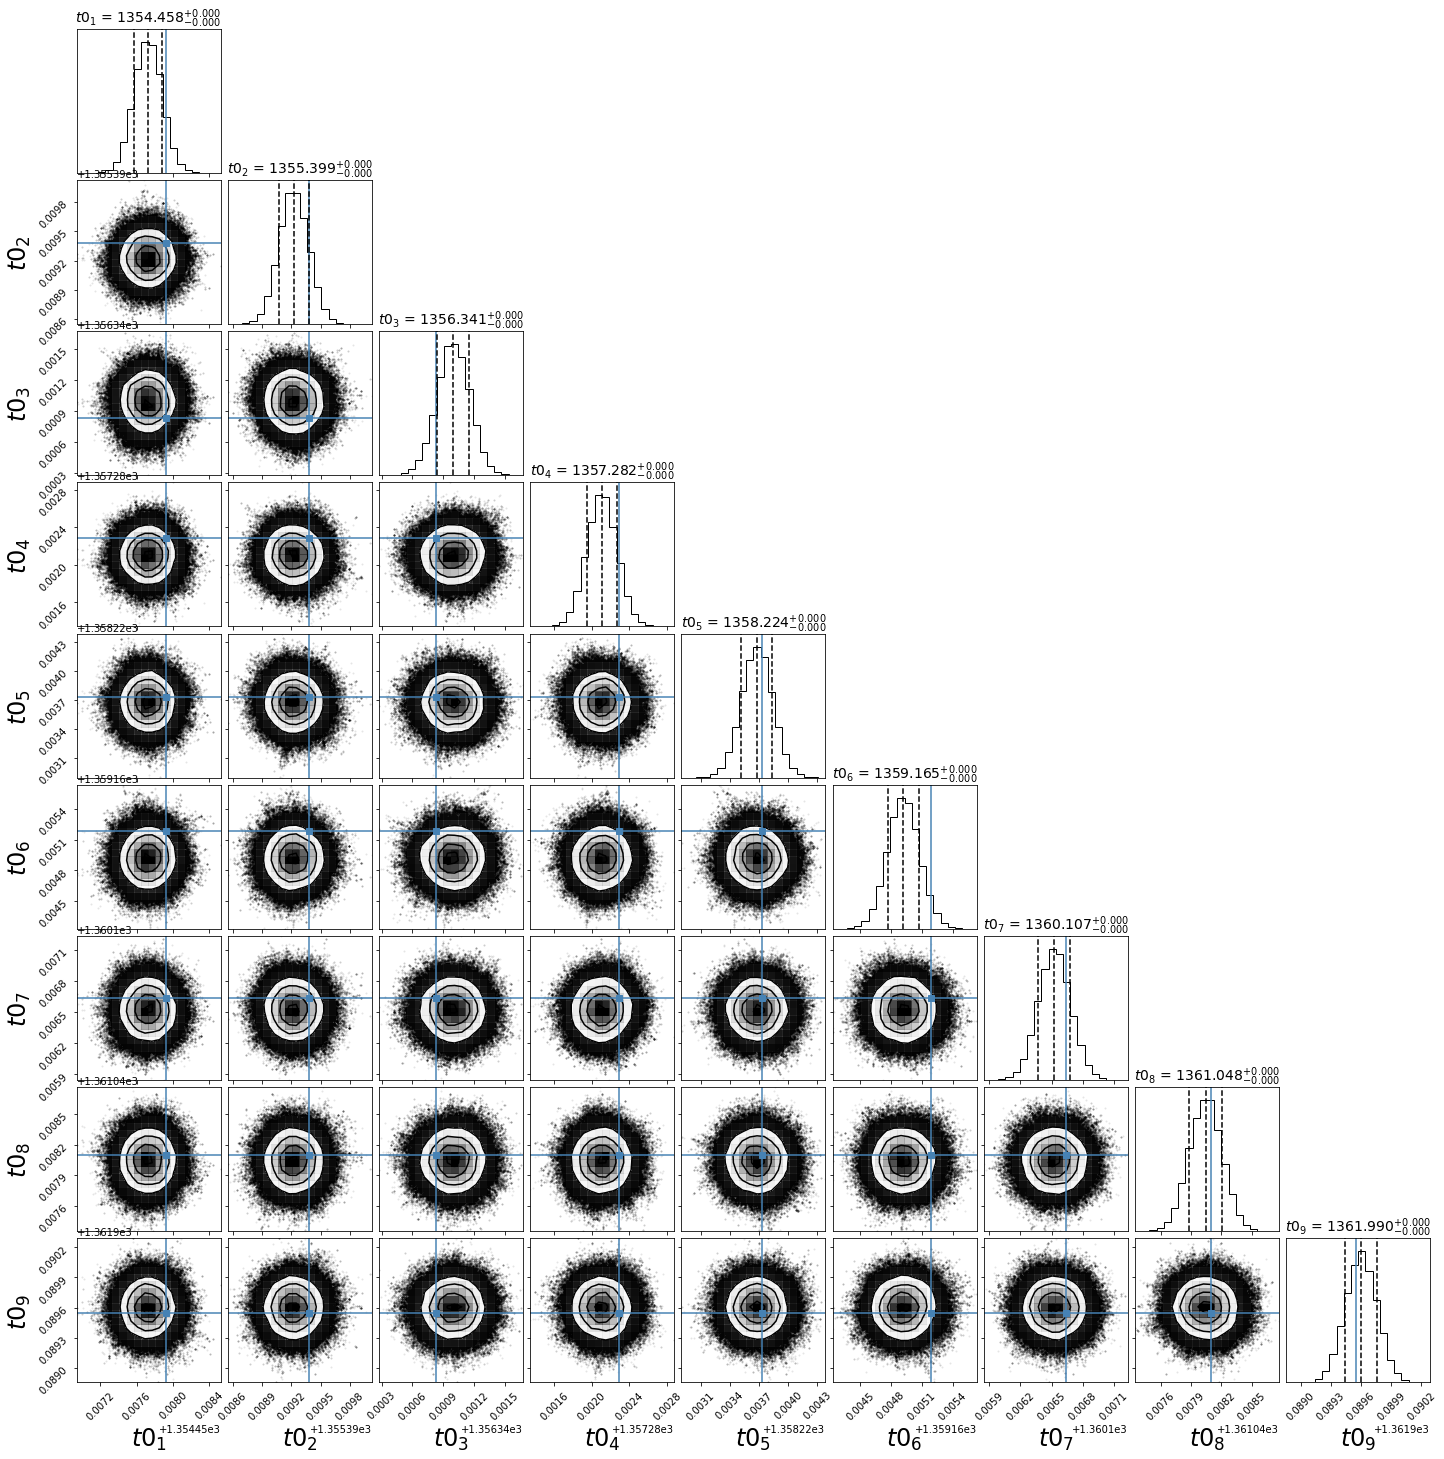

In [35]:
#show some of the t0 samples
#it takes very long to plot all and its very tiny
corner.corner(samples[:,5:14], labels=labels[5:14],show_titles=True, truths=np.array(t0s)[:9],
                    title_fmt=".3f",quantiles=[0.16,0.5,0.84],title_kwargs={"fontsize": 14},
                    label_kwargs={"fontsize":24});

blue horizontal lines are the T0 of transit time was strictly periodic

### Derive and plot TTVS

Deviations from expected time if transits were strictly periodic

In [36]:
#subtract median of t0 samples from the expected T0s values for periodic transits
ttv = (np.median(samples[:,5:], axis =0) - np.array(t0s))*24*3600   #subr


In [37]:
#Errors from the mcmc
ttvmin = (np.median(samples[:,5:], axis =0) - np.percentile(samples[:,5:], 16, axis=0))*24*3600
ttvmax = (np.percentile(samples[:,5:], 84, axis=0) - np.median(samples[:,5:], axis =0))*24*3600
errs = np.stack((ttvmin, ttvmax), axis=0)

In [38]:
np.mean(errs)  #seconds

13.652809317864012

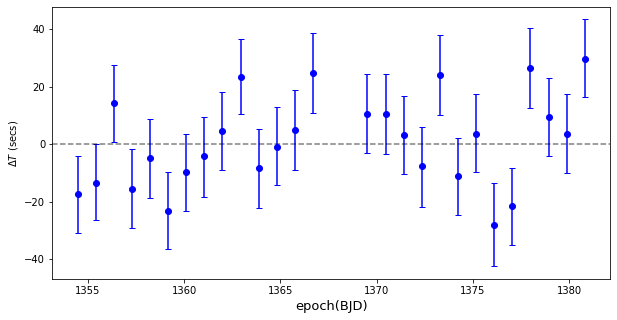

In [39]:
fig = plt.figure(figsize=(10,5))

plt.errorbar(t0s, ttv, errs, fmt="bo", capsize=3)
plt.xlabel(f"epoch(BJD)", fontsize=13);
plt.ylabel("$\\Delta T$ (secs)")
#plt.ylim([-100,150])
plt.axhline(0, ls="dashed", c="k", alpha=0.5);

In [40]:
fitparams = np.median(samples, axis =0)

fit_ttv = bat_ttv_model(fitparams, split_t)

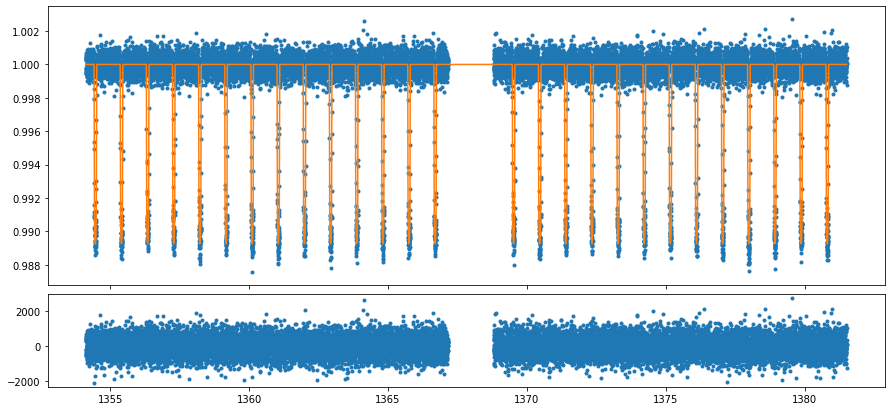

In [43]:

fig, ax = plt.subplots(2,1,figsize=(15,7), sharex=True, gridspec_kw={"height_ratios":(3,1)})
ax[0].plot(t,y,".")
ax[0].plot(t, fit_ttv)
ax[1].plot(t, 1e6*(y-fit_ttv),".")
plt.subplots_adjust(hspace=0.05)